In [1]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np

YEAR = 2021
filePath = '/Users/Firefly/Desktop/_iMac_Drive/Joseph/Coding/NFL/Jupyter/'

data = nfl.import_pbp_data([YEAR])
team_desc = nfl.import_team_desc()

# These two lines set the scroll options so you can scroll vertically and horizontally.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)



2021 done.
Downcasting floats.


In [2]:
# Copy data to new df
st = data.copy()

# Make new columns for kicking_team and receiving_team
st['kicking_team'] = np.where(st.play_type_nfl=='KICK_OFF', st.defteam, np.where(
                                st.play_type_nfl=='PUNT', st.posteam, None))
st['receiving_team'] = np.where(st.play_type_nfl=='KICK_OFF', st.posteam, np.where(
                                st.play_type_nfl=='PUNT', st.defteam, None))

st = st.loc[st.play_type_nfl.isin(['KICK_OFF'])]

st = st.filter(['week', 'desc', 'kicking_team', 'receiving_team', 'yardline_100', 
                'kick_distance', 'touchback', 'kickoff_in_endzone', 
                'kickoff_fair_catch', 'own_kickoff_recovery', 'fumble', 
                'kickoff_returner_player_name', 'return_yards', 'penalty_team', 
                'penalty_yards', 'penalty_type', 'drive_start_yard_line', 
                'fixed_drive_result', 'drive_end_transition'])



# assign team
TEAM = 'KC'

# Filter df
st = st.loc[(st.touchback==0.0) & (st.kickoff_in_endzone==1.0)]


# Assign maxWeek as the latest week with team data
maxWeek = st['week'].max()

# Kickoff return yards are inclusive of the yards it takes to run out 
# of the end zone. So a kick fielded 5 yards deep and returned to the 
# 20 yard line would be recorded as a 25 yard return. 
# We need actual return yards, and no field in nflfastR gives it to us,
# so we have work to do. 

# All kickoffs have the same desc format, and we need to get 
# the number of yards deep in the end zone the kick was fielded
# Split the desc field at the first period and space. 
st[['x', 'y']] = st['desc'].str.split('\. ', 1, expand=True)

# After the split, grab the last character from string x. 
# That will be the number of yards deep in the end zone
st['desc_yards'] = st['x'].str[-1]

# Finally, we can create a 'yards_in_endzone' data field with this data. 
# So when it was kicked into the endzone and wasn't a touchback,
# this returns the 'desc_yards' column we created. Otherwise, just a zero.
st['yards_in_endzone'] = np.where(
                    (st.kickoff_in_endzone==1.0) & (st.touchback==0.0), 
                    st.desc_yards, 0)
st['yards_in_endzone'] = st.yards_in_endzone.astype(int)

# Now we take return yards and subtract yards_in_endzone from it
st['return_yards_actual'] = st.return_yards.astype(int) - st.yards_in_endzone.astype(int)

# Here we're setting a field for where the kickoff return actually starts.
# We set it at 0 if it was in the end zone, or we do some math from the yardline and kick distance if it wasn't.
st['kick_end_yard_line_100'] = np.where(st.kickoff_in_endzone==1.0, 0, (100 - (st.yardline_100 + st.kick_distance)))

# Now we're going to set the field_position_after_kick. 
# If a touchback, then the 25 yard line,
# else if a penalty on receiving team, then kick end + return yards - penalty yards
# else if a penalty on the kicking team, then kick end + return yards + penalty yards
# else kick end + return yards.
st['field_position_after_kick'] = np.where(st.touchback==1.0, 25, 
                                           np.where(st.penalty_team==st.receiving_team, 
                                                    (st.kick_end_yard_line_100 + st.return_yards_actual) - st.penalty_yards, 
                                           np.where(st.penalty_team==st.kicking_team, 
                                                    (st.kick_end_yard_line_100 + st.return_yards_actual) + st.penalty_yards, 
                                                    (st.kick_end_yard_line_100 + st.return_yards_actual))))

# copy our df and filter it down to the fields we care about. 
st1 = st.copy()
st1 = st1.filter(['week', 'kicking_team', 'receiving_team', 'touchback', 
                  'kickoff_in_endzone', 'penalty_team', 'penalty_yards', 'yards_in_endzone',
                  'return_yards_actual', 'field_position_after_kick'])

# Probably don't need to copy it again, but I was getting deprecation warnings. 
st2 = st1.copy()
st2 = st2.loc[st2.kickoff_in_endzone==1.0]

# Probably don't need to copy it again, but I was getting deprecation warnings. 
st3 = st2.copy()
st3 = st2.groupby('receiving_team').agg({'return_yards_actual':'mean',
                                        'field_position_after_kick':'mean',
                                        'yards_in_endzone':'mean', 
                                        'kickoff_in_endzone':'sum'}).sort_values(by='yards_in_endzone', ascending=True)
st3 = st3.reset_index()

# Create a step variable to multiply the index number by to set up a consistent vertical spacing.
# The field heighth is 53.3, so we're going to divide that by the team count
step = 53 / st3.receiving_team.count()

# You have to create the column AFTER you've sorted and reset the index
st3['stepped'] = (st3.index * step) + (step / 2)
st3


,receiving_team,return_yards_actual,field_position_after_kick,yards_in_endzone,kickoff_in_endzone,stepped
0,IND,26.666667,26.666667,0.000000,3.0,0.828125
1,DEN,20.666667,20.666667,0.333333,3.0,2.484375
2,TB,21.400000,21.400000,0.400000,5.0,4.140625
3,LV,22.750000,22.750000,0.500000,4.0,5.796875
4,LA,18.750000,18.750000,0.500000,4.0,7.453125
5,SF,37.333333,37.333333,0.666667,3.0,9.109375
6,BAL,21.666667,21.666667,0.666667,3.0,10.765625
7,WAS,29.900000,28.900000,0.700000,10.0,12.421875
8,BUF,24.666667,21.333333,1.000000,3.0,14.078125
9,DAL,22.750000,17.500000,1.250000,4.0,15.734375


In [3]:
# Filter team_desc to just the necessary columns
team_df = team_desc.filter(['team_abbr', 'team_color'])

# Merge df with team df
df = pd.merge(st3, team_df, how = 'inner', left_on = 'receiving_team', right_on = 'team_abbr')


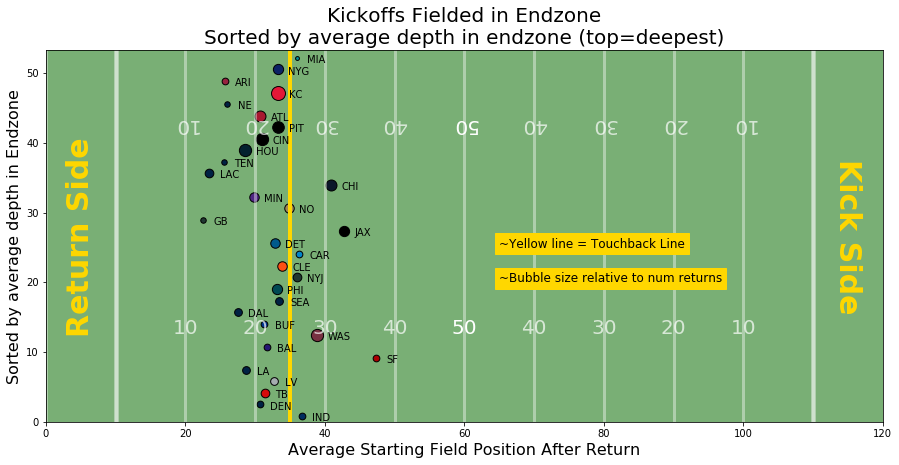

In [5]:
import matplotlib.pyplot as plt
import pylab as pl

# Create figure
fig, ax = pl.subplots()

# Set field dimensions
plt.xlim(0, 120)  # Field length including endzones
plt.ylim(0, 53.3)  # field width

# Set field color green
ax.set_facecolor('#79af75')
ax.set_alpha(0.5)

# Print lines
for i in range(0, 120, 10):
    plt.axvline(i, color='white', linewidth=3, alpha=0.4, zorder=1)
    if i == 10 or i == 110:  # Make endzone lines
        plt.axvline(i, color='white', linewidth=5, alpha=0.4, zorder=1)

# Add 25 yard line for touchback        
plt.axvline(35, color='gold', linewidth=4, alpha=1, zorder=1)

# Paint numbers
yds_from_sideline = 12
for i in range(10, 50, 10):
    plt.text(i+10, 53.3-yds_from_sideline, str(i), color='white', alpha=0.7, fontsize=20, verticalalignment='bottom', horizontalalignment='center', rotation=180)
    plt.text(110-i, 53.3-yds_from_sideline,  str(i), color='white', alpha=0.7, fontsize=20, verticalalignment='bottom', horizontalalignment='center', rotation=180)

    plt.text(i+10, yds_from_sideline, str(i), color='white', alpha=0.7, fontsize=20, verticalalignment='bottom', horizontalalignment='center')
    plt.text(110-i, yds_from_sideline, str(i), color='white', alpha=0.7, fontsize=20, verticalalignment='bottom', horizontalalignment='center')

# Paint 50 yard line numbers
plt.text(60, 53.3-yds_from_sideline, str(50), color='white', fontsize=20, verticalalignment='bottom', horizontalalignment='center', rotation=180)
plt.text(60, yds_from_sideline, str(50), color='white', fontsize=20, verticalalignment='bottom', horizontalalignment='center')

# Print something in the endzones
plt.text(5, 26.5, 'Return Side', color='gold', fontweight='bold', fontsize=30, verticalalignment='center', horizontalalignment='center', rotation=90)
plt.text(115, 26.5, 'Kick Side', color='gold', fontweight='bold', fontsize=30, verticalalignment='center', horizontalalignment='center', rotation=270)



# Start adding Kickoff information

#add data to chart
for receiving_team, row in df.iterrows():
    plt.scatter(row['field_position_after_kick'] + 10, row['stepped'], label=receiving_team, c=row['team_color'], edgecolors='black', alpha=1, s=(row['kickoff_in_endzone'] * 15))

#append names and allows to adjust below
texts = []
for x, y, s in zip(df['field_position_after_kick'] + 10, df['stepped'], df['receiving_team']):
    texts.append(plt.text(x+1.5, y-.7, s))

# Add descriptive text to the field. 
ax.text(65, 20, '~Bubble size relative to num returns', fontsize=12, color='black', backgroundcolor='gold')
ax.text(65, 25, '~Yellow line = Touchback Line', fontsize=12, color='black', backgroundcolor='gold')



title_text = 'Kickoffs Fielded in Endzone'
plt.title(str(title_text) + '\nSorted by average depth in endzone (top=deepest)', fontsize=20)
plt.ylabel('Sorted by average depth in Endzone', fontsize=16)
plt.xlabel('Average Starting Field Position After Return', fontsize=16)

# Fix the aspect ratio (optional)
plt.gca().set_aspect(1)

fig_size = plt.gcf().get_size_inches() # Get current size
sizefactor = 2.5 # Set a zoom factor
# Modify the current size by the factor
plt.gcf().set_size_inches(sizefactor * fig_size) 

#Save the figure as a png
plt.savefig(filePath + 'Figures/' + str(title_text) + '.png', bbox_inches='tight', dpi=400)
plt.show()
